## Project 2 Baseline
Quora Project



# GBClassifier

# Load Data and Import Libraries

First, we load all data and necessary libraries. We split the `train` data into `miniTrain` and `miniTest` dataframes.



In [2]:
#Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier, DMatrix
# import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, plot_confusion_matrix
from sklearn_pandas import DataFrameMapper
import csv
import random

In [2]:
!pip install delayed

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
# # Code to read csv file from Google Drive into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [4]:
# #Load test DF
# testLink = 'https://drive.google.com/file/d/1chKVOcXwNzGRe_hRxpGlq18NVaSRM8X9/view?usp=sharing'
# idTest = testLink.split('/')[-2]
# downloaded = drive.CreateFile({'id':idTest}) 
# downloaded.GetContentFile('test.csv')  
# test = pd.read_csv('test.csv')

In [7]:
columns = [
    "id",
    "label",
    "alpha",
    "text"
]

miniTrain = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/train.tsv', names=columns, sep="\t")

miniTest = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/test.tsv', names=columns, sep="\t")

miniDev = pd.read_csv('/Users/julian.hicks/Documents/mids/w207ml/W207FinalProject/datasets/dev.tsv', names=columns, sep="\t")

In [6]:
# #Load train DF
# trainLink = 'https://drive.google.com/file/d/1fP-AWiUGLjLkL0c_u67HOUFmHOMO7qm2/view?usp=sharing'
# idTrain = trainLink.split('/')[-2]
# downloaded = drive.CreateFile({'id':idTrain}) 
# downloaded.GetContentFile('train.csv')  

In [4]:
# train = pd.read_csv('train.csv')
# train

In [5]:
# #Split Training Data into MiniTrain and MiniTest (Test data has no labels so impossible to measure error from it)
# # random.seed(10)
# # miniTrain, miniDev, miniTest = train_test_split(train, test_size=0.2)

# miniTrain, miniDev, miniTest = \
#               np.split(train.sample(frac=1, random_state=42), 
#                        [int(.8*len(train)), int(.9*len(train))])

# miniTrain.to_csv('miniTrain.csv', index=False)

# miniTest.to_csv('miniTest.csv', index=False)

# miniDev.to_csv('miniDev.csv', index = False)

# print("miniTrain: ",len(miniTrain), "observations, ", round(len(miniTrain)/len(train)*100,0), "%;\n" ,
#       "miniDev: ",len(miniDev), "observations, ", round(len(miniDev)/len(train)*100,0), "%;\n" ,
#       "miniTest: ",len(miniTest), "observations, ", round(len(miniTest)/len(train)*100,0), "%;" )

In [9]:
# #Even with a seed the randomization is messing up predictions since miniTest will not find the same questions further down, 
# #so rather load a static version from a csv instead.

# miniTrain = pd.read_csv('miniTrain.csv')

# miniTest = pd.read_csv('miniTest.csv')

# miniDev = pd.read_csv('miniDev.csv')

## `txtprp` Module 

In [13]:
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import nltk as nltk
import re
import gensim 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

class TextObject(pd.DataFrame):
    """
    A collection of strings for processing. Is a DataFrame with specific 
    columns. 
    """

    def __init__(self):
        super().__init__(columns=[
            "original_text",
            "text",
            "label"
        ]
        )
        self._attrs["applied_transformations"] = []
        nltk.download("stopwords")
        nltk.download("punkt")

    def add_text(self, text_collection, labels=None):
        """
        Adds a collection of text to to the TextObject. Accepts an iterable or 
        array-like of all text strings. Optionally, accepts labels of the same 
        length. Modifies self to be a pandas DataFrame with column "text" and 
        potentially "labels".
        """
        self["original_text"] = text_collection
        self["text"] = self.original_text
        self._attrs["applied_transformations"] = []
        if type(labels) == type(None):
            return
        if len(labels) == len(self):
            self["label"] = labels

    # Text Processing Methods:

    def text_processing(self, function):
        """
        Applies a generic text processing function to the self.text field.
        """
        self.text = self.text.apply(function)
        self._attrs["applied_transformations"].append(function.__name__)

    def lower(self):
        self.text = self.text.str.lower()
        self._attrs["applied_transformations"].append("lower")
    
    def strip(self):
        self.text = self.text.str.strip()
        self._attrs["applied_transformations"].append("strip")

    def remove_single_digits(self):
        self.text = self.text.apply(lambda text: re.sub("([\d]+)", "", text))
        self._attrs["applied_transformations"].append("remove_single_digits")
    
    def remove_nonletter_chars(self):
        self.text = self.text.apply(lambda text: re.sub("[^A-Za-z0-9 \\n]", " ", text))
        self._attrs["applied_transformations"].append("remove_nonletter_chars")

    def stop_word_tokenize(self):
        def tokenize(text):
            self.stoplist = nltk.corpus.stopwords.words('english')
            finalTokens = []
            tokens = nltk.word_tokenize(text)
            for w in tokens:
                if (w not in self.stoplist):
                    finalTokens.append(w)
            text = " ".join(finalTokens)
            return text
        self.text = self.text.apply(tokenize)
        self._attrs["applied_transformations"].append("stop_word_tokenize")
    
    def stem_sentence(self):
        def stem(text):
            porter=PorterStemmer()
            token_words=nltk.tokenize.word_tokenize(text)
            token_words
            stem_sentence=[]
            for word in token_words:
                stem_sentence.append(porter.stem(word))
                stem_sentence.append(" ")
            return "".join(stem_sentence)
        self.text = self.text.apply(stem)
        self._attrs["applied_transformations"].append("stem_sentence")

    def lemmatize_sentence(self):
        def lem(text):
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            #token_words
            token_words=nltk.tokenize.word_tokenize(text)
            lemm_sentence=[]
            for word in token_words:
                lemm_sentence.append(wordnet_lemmatizer.lemmatize(word))
                lemm_sentence.append(" ")
            return "".join(lemm_sentence)
        self.text = self.text.apply(lem)
        self._attrs["applied_transformations"].append("lemmatize_sentence")

    def process_all(self, lower=True, strip=True, remove_single_digits =True, 
        remove_nonletter_chars=True, stop_word_tokenize=True, stem_sentence=True,
        lemmatize_sentence=True):
        if lower:
            self.lower()
        if strip:
            self.strip()
        if remove_single_digits:
            self.remove_single_digits()
        if remove_nonletter_chars:
            self.remove_nonletter_chars()
        if stop_word_tokenize:
            self.stop_word_tokenize()
        if stem_sentence:
            self.stem_sentence()
        if lemmatize_sentence:
            self.lemmatize_sentence()



# GBClassifier

In [15]:
train = TextObject()
train.add_text(miniTrain.text, labels=miniTrain.label)
print(train.__dict__)
train

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=1044897, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 1044897, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 1044897, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,What is the most effective classroom managemen...,What is the most effective classroom managemen...,0
1,Can I study abroad after 10th class from Bangl...,Can I study abroad after 10th class from Bangl...,0
2,How can I make friends as a college junior?,How can I make friends as a college junior?,0
3,How do I download free APK Minecraft: Pocket E...,How do I download free APK Minecraft: Pocket E...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...","Like Kuvera, is ""Groww"" also a free online inv...",0
...,...,...,...
1044892,How is a video similar to ordinary graphics?,How is a video similar to ordinary graphics?,0
1044893,How does training with a speed bag make you a ...,How does training with a speed bag make you a ...,0
1044894,What marketing strategies are implemented to i...,What marketing strategies are implemented to i...,0
1044895,What are the characteristics of wireless adapt...,What are the characteristics of wireless adapt...,0


In [16]:
test = TextObject()
test.add_text(miniTest.text, labels=miniTest.label)
print(test.__dict__)
test

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=130612, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 130612, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 130612, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,Does my BDS degree from India count if I want ...,Does my BDS degree from India count if I want ...,0
1,Is there such a thing as an average face?,Is there such a thing as an average face?,0
2,Is Munich Volkshochschule a good choice to lea...,Is Munich Volkshochschule a good choice to lea...,0
3,What is The relationship between Texas and its...,What is The relationship between Texas and its...,0
4,Will the current mining equipment work with se...,Will the current mining equipment work with se...,0
...,...,...,...
130607,What's the best way to teach your daughter to ...,What's the best way to teach your daughter to ...,0
130608,What are similarities and differences between ...,What are similarities and differences between ...,0
130609,What is the best shoe cleaning product for tri...,What is the best shoe cleaning product for tri...,0
130610,Can I get a private medical college with 320 m...,Can I get a private medical college with 320 m...,0


In [17]:
dev = TextObject()
dev.add_text(miniDev.text, labels=miniDev.label)
print(dev.__dict__)
dev

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['original_text', 'text', 'label'], dtype='object')
Axis 1: RangeIndex(start=0, stop=130613, step=1)
ObjectBlock: slice(0, 2, 1), 2 x 130613, dtype: object
NumericBlock: slice(2, 3, 1), 1 x 130613, dtype: int64, '_item_cache': {}, '_attrs': {'applied_transformations': []}, '_flags': <Flags(allows_duplicate_labels=True)>}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julian.hicks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,original_text,text,label
0,Where can I find best romantic shayaris?,Where can I find best romantic shayaris?,1
1,When we check the UPSC rank list; many of the ...,When we check the UPSC rank list; many of the ...,0
2,Is there is any web site to create search engi...,Is there is any web site to create search engi...,0
3,How can you earn $50 just clicking ads?,How can you earn $50 just clicking ads?,0
4,Which 3 branches of engineering have the most ...,Which 3 branches of engineering have the most ...,0
...,...,...,...
130608,How can the ViewSonic PA503S 3600 lumens SVGA ...,How can the ViewSonic PA503S 3600 lumens SVGA ...,0
130609,What are the biggest myths about Adolf Hitler?,What are the biggest myths about Adolf Hitler?,0
130610,What song played in the movie of the gifted wh...,What song played in the movie of the gifted wh...,0
130611,"What do Socrates, Thomas Kuhn and Karl Popper ...","What do Socrates, Thomas Kuhn and Karl Popper ...",0


In [18]:
train.lower()
train.strip()
train.remove_single_digits()
train.remove_nonletter_chars()
train.stop_word_tokenize()

<ipython-input-13-264db1470b1d>:69: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.stoplist = nltk.corpus.stopwords.words('english')


In [19]:
train

,original_text,text,label
0,What is the most effective classroom managemen...,effective classroom management skill technique...,0
1,Can I study abroad after 10th class from Bangl...,study abroad th class bangladesh,0
2,How can I make friends as a college junior?,make friends college junior,0
3,How do I download free APK Minecraft: Pocket E...,download free apk minecraft pocket edition ios...,0
4,"Like Kuvera, is ""Groww"" also a free online inv...",like kuvera groww also free online investment ...,0
...,...,...,...
1044892,How is a video similar to ordinary graphics?,video similar ordinary graphics,0
1044893,How does training with a speed bag make you a ...,training speed bag make better fighter,0
1044894,What marketing strategies are implemented to i...,marketing strategies implemented increase sale...,0
1044895,What are the characteristics of wireless adapt...,characteristics wireless adapters,0


In [20]:
for m in train._attrs["applied_transformations"]:
    getattr(dev, m)()
    getattr(test, m)()

<ipython-input-13-264db1470b1d>:69: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.stoplist = nltk.corpus.stopwords.words('english')


In [21]:
#Vectorize Data

cv = CountVectorizer()
train_cv = cv.fit_transform(train.text)
dev_cv = cv.transform(dev.text)
test_cv = cv.transform(test.text)


In [18]:
# # Convert data into xgb data matrix
# train_dm = DMatrix(train_cv,pd.Series(train.label))
# dev_dm = DMatrix(dev_cv,dev.label)
# test_dm = DMatrix(test_cv,test.label)


In [19]:
# model = XGBClassifier()
# model.fit(train_cv, train.label)
# dev_preds = model.predict(dev_cv)
# print(classification_report(dev.label, dev_preds))

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


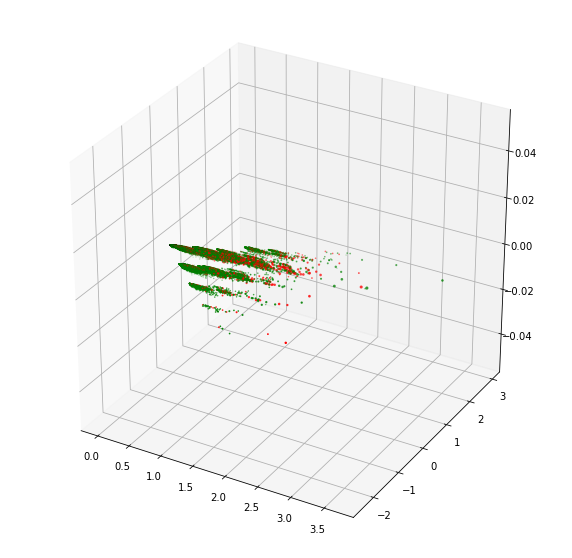

In [22]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 3)
rd_train = svd.fit_transform(train_cv, train.label)

rd_train = pd.DataFrame(rd_train)
colors = ['g','r']
cmap = [colors[i] for i in train.label]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
plt.scatter(rd_train[0],rd_train[1], rd_train[2], c=cmap)

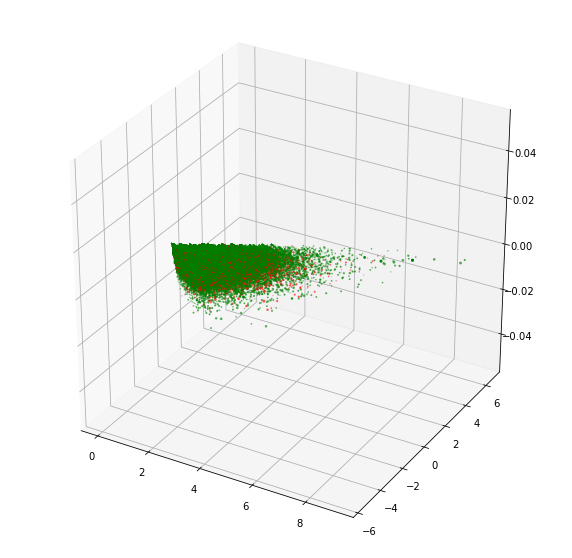

In [23]:
cv2 = CountVectorizer()
train_cv2 = cv2.fit_transform(train.original_text)

svd2 = TruncatedSVD(n_components = 3)
rd_train2 = svd2.fit_transform(train_cv2, train.label)

rd_train2 = pd.DataFrame(rd_train2)
colors = ['g','r']
cmap = [colors[i] for i in train.label]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
plt.scatter(rd_train2[0],rd_train2[1], rd_train2[2], c=cmap, alpha = 0.5)

In [24]:
#Vectorize Data

tv = TfidfVectorizer()
train_tv = tv.fit_transform(train.text)
dev_tv = tv.transform(dev.text)
test_tv = tv.transform(test.text)

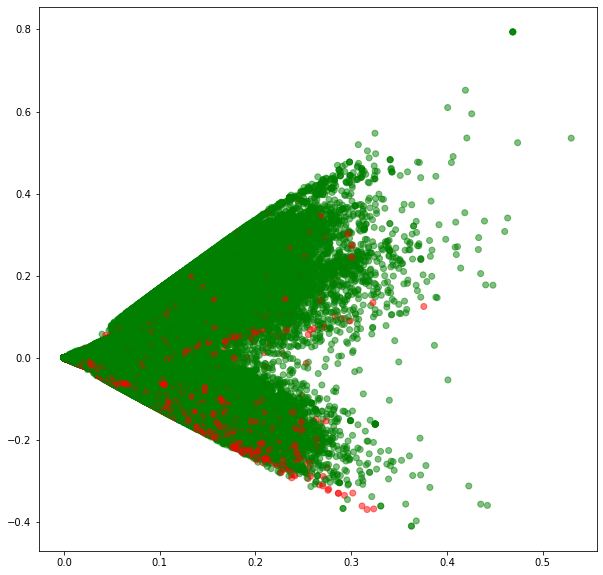

In [25]:
svd = TruncatedSVD(n_components = 2)
rd_train = svd.fit_transform(train_tv, train.label)

rd_train = pd.DataFrame(rd_train)
colors = ['g','r']
cmap = [colors[i] for i in train.label]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
plt.scatter(rd_train[0],rd_train[1],  c=cmap, alpha=0.5)

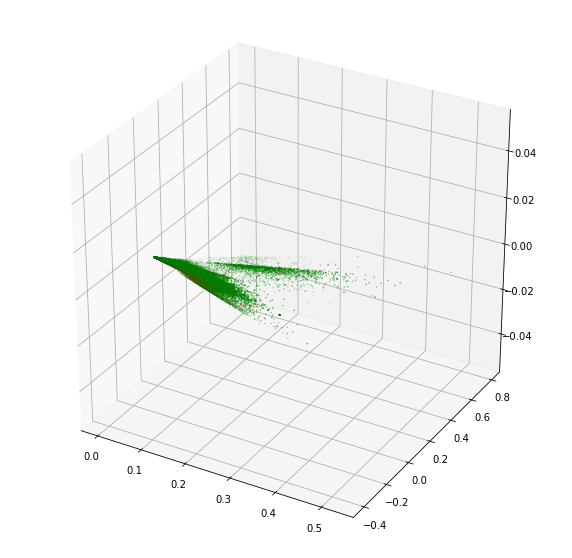

In [26]:
svd = TruncatedSVD(n_components = 3)
rd_train = svd.fit_transform(train_tv, train.label)

rd_train = pd.DataFrame(rd_train)
colors = ['g','r']
cmap = [colors[i] for i in train.label]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
plt.scatter(rd_train[0],rd_train[1], rd_train[2], c=cmap, alpha=0.5)

In [28]:
print(train_tv_os.shape)

(1960790, 159547)


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

os = RandomOverSampler()
train_tv_os, train_label_os = os.fit_resample(train_tv, train.label)

param_grid = {
    "max_features": [500,1000,1500,5000],
    "max_depth": [2,3,4,5],
    "n_estimators": [500,1000,1500]
}

gbc = GradientBoostingClassifier()
search = HalvingGridSearchCV(gbc, param_grid, 
                             min_resources=1000, 
                             max_resources=100000, 
                             factor=3,
                             cv=3,
                             scoring='f1'
                             ).fit(train_tv_os, train_label_os)


In [33]:
search.best_params_

{'max_depth': 5, 'max_features': 500, 'n_estimators': 1500}

In [34]:
param_grid = {
    "max_features": [400,500,600],
    "max_depth": [4,5,6],
    "n_estimators": [1250,1500,1750]
}

gbc = GradientBoostingClassifier()
search = HalvingGridSearchCV(gbc, param_grid, 
                             min_resources=1000, 
                             max_resources=100000, 
                             factor=3,
                             cv=3,
                             scoring='f1'
                             ).fit(train_tv_os, train_label_os)

In [35]:
search.best_params_

{'max_depth': 5, 'max_features': 400, 'n_estimators': 1500}

In [36]:
gbc = GradientBoostingClassifier(max_depth=5,
                                 max_features=400,
                                 n_estimators=1500,
                                 verbose=1)
gbc.fit(train_tv_os, train_label_os)


      Iter       Train Loss   Remaining Time 
         1           1.3837           23.00m
         2           1.3820           21.59m
         3           1.3807           20.15m
         4           1.3799           19.11m
         5           1.3775           18.45m
         6           1.3767           18.24m
         7           1.3745           18.14m
         8           1.3709           17.94m
         9           1.3700           17.64m
        10           1.3694           17.38m
        20           1.3478           17.02m
        30           1.3247           16.77m
        40           1.3050           16.41m
        50           1.2883           16.40m
        60           1.2719           16.17m
        70           1.2533           16.03m
        80           1.2396           15.99m
        90           1.2278           15.92m
       100           1.2138           15.79m
       200           1.0948           15.09m
       300           1.0189           14.20m
       40

GradientBoostingClassifier(max_depth=5, max_features=400, n_estimators=1500,
                           verbose=1)

In [38]:
dev_preds = gbc.predict(dev_tv)
dev_pred_proba = gbc.predict_proba(dev_tv)
print(classification_report(dev.label, dev_preds)) 

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    122465
           1       0.36      0.82      0.50      8148

    accuracy                           0.90    130613
   macro avg       0.67      0.86      0.72    130613
weighted avg       0.95      0.90      0.92    130613



In [39]:
print(dev_preds[:10])
print(dev_pred_proba[:10])
dev_pred_proba[:,1]

[0 0 0 0 0 0 0 0 0 0]
[[0.93342783 0.06657217]
 [0.87223615 0.12776385]
 [0.88495094 0.11504906]
 [0.81554458 0.18445542]
 [0.94860942 0.05139058]
 [0.784564   0.215436  ]
 [0.87317968 0.12682032]
 [0.77655614 0.22344386]
 [0.86246038 0.13753962]
 [0.86501685 0.13498315]]


array([0.06657217, 0.12776385, 0.11504906, ..., 0.13153566, 0.23303094,
       0.17580642])

In [ ]:
# # Trying AdaBoost

# ada_model = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=1,
#                            max_features=1000),
#     n_estimators=50
# )

# ada_model.fit(train_cv, train.text)

In [ ]:
# ada_dev_preds = ada_model.predict_proba(dev_cv)
# print(classification_report(dev.label,ada_dev_preds))

In [52]:


calcDF = pd.DataFrame(data=[dev_pred_proba[:,1]], index=['pred']).T
calcDF["label"] = dev.label
calcDF


NameError: name 'dev_prob' is not defined

In [41]:

def frange(start, stop, step):
  i = start
  while i < stop:
    yield i
    i += step

columnNames = ['threshold', 'f1Score', 'accuracy', 'recall', 'precision']
thresholdDF = pd.DataFrame(columns=columnNames)

for i in frange(0.05,1,0.05):
  calcDF['pred2'] = np.where(calcDF['pred'] > i, 1, 0)
  f1Score = f1_score(calcDF.label, calcDF.pred2)
  accuracy = accuracy_score(calcDF.label, calcDF.pred2)
  recall = recall_score(calcDF.label, calcDF.pred2)
  precision = precision_score(calcDF.label, calcDF.pred2)
  thresholdDF = thresholdDF.append({'threshold': i, 'f1Score': f1Score, 
                                    'accuracy':accuracy, 'recall':recall, 
                                    'precision':precision}, 
                                   ignore_index=True)

thresholdDF

,threshold,f1Score,accuracy,recall,precision
0,0.05,0.120521,0.089769,0.999755,0.064126
1,0.10,0.132741,0.187148,0.997177,0.071103
2,0.15,0.157225,0.336965,0.991409,0.085383
3,0.20,0.196657,0.500655,0.979750,0.109298
4,0.25,0.291815,0.710779,0.955204,0.172213
5,0.30,0.347111,0.781829,0.929676,0.213392
6,0.35,0.393356,0.825791,0.905376,0.251260
7,0.40,0.432423,0.855734,0.880952,0.286535
8,0.45,0.467191,0.878649,0.852847,0.321713
9,0.50,0.501541,0.898494,0.818606,0.361518


In [42]:
optimumThreshold = thresholdDF.loc[thresholdDF['f1Score'].idxmax()][0]

optimumThreshold

0.65

In [53]:
dev_final = dev.copy()
dev_final["prediction"] = calcDF.pred.apply(lambda x: int(x>optimumThreshold))
mispred = dev_final[dev_final.label != dev_final.prediction].reset_index()

for i in range(400,420):
    print(mispred.label[i], mispred.prediction[i], mispred.original_text[i], )

0 1 Did George Washington believe that black people were inferior?
0 1 Why do I feel that there is a standard of beauty for women to be on TV (especially for the news)?
1 0 Would it be easier to my ask my first cusion to have sex with me are tell her I'm I love with her?
0 1 Why do most European immigrants in the USA hate non-European immigrants?
0 1 How can I respond to the argument that Trump supports are "sexist"?
0 1 Why don't more Americans take up martial arts instead of carrying guns?
0 1 Do you think most migrants and refugees will return after all settles down in their countries? Should we stop migrants so we can help actual refugees?
0 1 Why does Kanye West have a higher opinion of Donald Trump than he had of George W. Bush?
1 0 Will Mr. Putin ever return the ring he has stolen?
0 1 Who would win in a presidential election between Donald Trump and Eisenhower in 2016?
0 1 How do women pleasure themselves with long fake nails?
0 1 Why are Pentecostal Christians not allowed to w

Accuracy: 0.9324110157488152
F1 score: 0.559129045145825
Recall: 0.687039764359352
Precision: 0.4713708319299427

 Clasification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96    122465
           1       0.47      0.69      0.56      8148

    accuracy                           0.93    130613
   macro avg       0.72      0.82      0.76    130613
weighted avg       0.95      0.93      0.94    130613


 Confusion matrix:



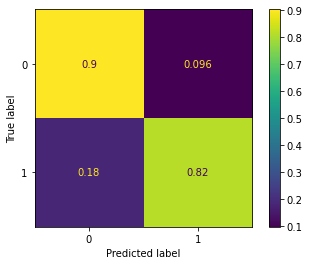

In [44]:
print('Accuracy:', accuracy_score(dev_final.label, dev_final.prediction))
print('F1 score:', f1_score(dev_final.label, dev_final.prediction))
print('Recall:', recall_score(dev_final.label, dev_final.prediction))
print('Precision:', precision_score(dev_final.label, dev_final.prediction))
print('\n Clasification report:\n', classification_report(dev_final.label, dev_final.prediction))
print('\n Confusion matrix:\n')
disp = plot_confusion_matrix(gbc, dev_tv, dev_final.label, normalize='true')

In [50]:
from joblib import dump, load

dump(gbc, 'gbmodel.joblib')
dump(tv, 'gb_tv.joblib')
dump(optimumThreshold, 'gb_ot.joblib')

['gb_ot.joblib']